# Spoken commands example
This example uses an audio classifier model from a Tensorflow tutorial:
https://www.tensorflow.org/tutorials/sequences/audio_recognition

**N.B. This script downloads a large (2.3GB) speech commands dataset!**

In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import tarfile
import shutil
import numpy as np
import pandas as pd
from scipy.io.wavfile import read, write
from sklearn.metrics import confusion_matrix
from dpemu.problemgenerator.series import Series
from dpemu.problemgenerator.tuple import Tuple
from dpemu.filters.sound import ClipWAV
from dpemu.filters.common import ApplyToTuple
from dpemu.plotting_utils import visualize_confusion_matrix

First we download the dataset unless it is already present.
If you have downloaded and extracted the dataset into a different directory,
change the data_dir variable accordingly.

In [2]:
data_url = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
fname = "speech_commands_v0.02.tar.gz"
data_dir = Path.home() / "datasets/speech_data"

if not data_dir.exists():
    data_dir.mkdir(parents=True)
    !wget {data_url} -P {data_dir}
    tarfile.open(data_dir / fname, "r:gz").extractall(data_dir)

In [3]:
trained_categories = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
labels = ["_silence_", "_unknown_", "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

test_set_rel_paths = !cat {data_dir / "testing_list.txt"}
test_set_files = [data_dir / p for p in test_set_rel_paths]
test_categories = !cut -d'/' -f1 {data_dir / "testing_list.txt"} | sort -u

len(test_set_files), len(test_categories), len(trained_categories)

(11005, 35, 10)

In order to download the speech commands dataset to the correct place, we need to set the variables dpemu_path and example_path.

In [4]:
dpemu_path = Path.cwd().parents[1]
example_path = dpemu_path / "examples/speech_commands"

Choose a category in which to generate errors.
Later on we will generate errors in all of the test set categories.

In [5]:
category = "stop"
data_subset_dir = data_dir / category

fs = list(data_subset_dir.iterdir())
wavs = [read(f) for f in data_subset_dir.iterdir()]

Create an error generating tree and generate errors
in the category chosen above.

In [6]:
wav_node = Tuple()
wav_node.addfilter(ApplyToTuple(ClipWAV("dyn_range"), 1))
root_node = Series(wav_node)

err_params = {"dyn_range": .2}
clipped = root_node.generate_error(wavs, err_params)

Now we arbitrarily choose a speech command example from the data subset. To try another audio clip, change the index.

In [7]:
example_index = 123

In [8]:
clipped_filename = data_dir / 'clipped.wav'
write(clipped_filename, 16000, clipped[example_index][1])

In [9]:
!aplay {fs[example_index]}

Playing WAVE '/home/jpssilve/datasets/speech_data/stop/3ec05c3d_nohash_0.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


In [10]:
!aplay {clipped_filename}

Playing WAVE '/home/jpssilve/datasets/speech_data/clipped.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


Define a function to filter out irrelevant output (e.g. Python deprecation warnings):

In [11]:
def filter_scores(output):
    return [line for line in output if "score" in line or ".wav" in line]

Run the model on the clean clip selected above:

In [12]:
scores_clean = !python {example_path}/label_wav.py \
--graph={example_path}/trained_model/my_frozen_graph.pb \
--labels={example_path}/trained_model/conv_labels.txt \
--wav={fs[example_index]}

filter_scores(scores_clean)

['stop (score = 0.54378)',
 'off (score = 0.19993)',
 '_unknown_ (score = 0.07233)']

Run the model on the corresponding errorified clip:

In [13]:
scores_clipped = !python {example_path}/label_wav.py \
--graph={example_path}/trained_model/my_frozen_graph.pb \
--labels={example_path}/trained_model/conv_labels.txt \
--wav={clipped_filename}

filter_scores(scores_clipped)

['stop (score = 0.22963)',
 'down (score = 0.16858)',
 '_unknown_ (score = 0.11415)']

You can also run the model on an entire directory of .wav files in one go:

In [14]:
scores_clean_dir = !python {example_path}/label_wav_dir.py \
--graph={example_path}/trained_model/my_frozen_graph.pb \
--labels={example_path}/trained_model/conv_labels.txt \
--wav_dir={data_subset_dir}

filter_scores(scores_clean_dir)

['0f46028a_nohash_4.wav',
 'stop (score = 0.84888)',
 'up (score = 0.10150)',
 '_unknown_ (score = 0.02897)',
 '095847e4_nohash_0.wav',
 'stop (score = 0.83839)',
 'up (score = 0.10791)',
 'down (score = 0.01377)',
 'f8ba7c0e_nohash_1.wav',
 'stop (score = 0.99616)',
 'down (score = 0.00215)',
 '_unknown_ (score = 0.00114)',
 '4cee0c60_nohash_1.wav',
 'stop (score = 0.94652)',
 'up (score = 0.04828)',
 '_unknown_ (score = 0.00210)',
 '52e228e9_nohash_1.wav',
 'stop (score = 0.98153)',
 'down (score = 0.00989)',
 'up (score = 0.00290)',
 '42f81601_nohash_0.wav',
 'stop (score = 0.95047)',
 'up (score = 0.02973)',
 '_unknown_ (score = 0.01149)',
 'bc065a17_nohash_1.wav',
 'stop (score = 0.51887)',
 'down (score = 0.33725)',
 '_unknown_ (score = 0.13488)',
 '692a88e6_nohash_1.wav',
 'stop (score = 0.83974)',
 'up (score = 0.15001)',
 '_unknown_ (score = 0.00472)',
 '96a48d28_nohash_0.wav',
 'stop (score = 0.99714)',
 '_unknown_ (score = 0.00153)',
 'up (score = 0.00119)',
 '763188c4_nohas

That was not pretty! We'd better define some helper functions to extract
the model's guesses from that messy output:

In [15]:
def get_guesses(scores):
    scores = filter_scores(scores)
    if len(scores) % 4 != 0:
        raise ValueError(f"Expected scores list to have a length divisible by 4 after filtering but got length {len(scores)}")
    num_files = len(scores) / 4
    fnames = scores[0::4]
    guesses = [guess.split(' ')[0] for guess in scores[1::4]]
    return zip(fnames, guesses)

def score_directory(directory):
    scores = !python {example_path}/label_wav_dir.py \
        --graph={example_path}/trained_model/my_frozen_graph.pb \
        --labels={example_path}/trained_model/conv_labels.txt \
        --wav_dir={directory}
    return filter_scores(scores)

Define a function to generate errors in all wav files in a given directory.
If an inclusion list is provided, only files on the list will be processed.

In [16]:
def errorify_directory(data_root_dir, dir_name, tree_root, err_params, inclusion_list=None):
    clean_data_dir = data_root_dir / dir_name
    if not clean_data_dir.exists():
        raise ValueError(f"Directory {clean_data_dir} does not exist.")
    err_data_dir = data_root_dir / (dir_name + "_err")
    if not err_data_dir.exists():
        err_data_dir.mkdir()
    if not inclusion_list:
        inclusion_list = [f for f in clean_data_dir.iterdir() if ".wav" in str(f)]
    for file in inclusion_list:
        fname = file.name
        wav = read(file)
        clipped = tree_root.generate_error([wav], err_params)[0]
        err_file_path = err_data_dir / fname
        write(err_file_path, clipped[0], clipped[1])
    return err_data_dir

Define a function to generate errors in all wav files on a list.
The function is needed when files from multiple categories are present on the list.
To facilitate comparisons between clean and errorified data, the clean files
the list can be automatically copied to suitably named directories. To do this,
provide the parameter copy_clean=True.

In [17]:
def errorify_list(data_files, categories, tree_root, err_params, copy_clean=False):
    data_root_dir = data_files[0].parents[1]
    for cat in categories:
        files_in_cat = [f for f in data_files if (cat + "/") in str(f)]
        print("category:", cat)
        print(f"{len(files_in_cat)}")
        errorify_directory(data_root_dir, cat, tree_root, err_params, inclusion_list=files_in_cat)
        if copy_clean:
            copy_dir = data_root_dir / (cat + "_clean")
            copy_dir.mkdir(exist_ok=True)
            for file in files_in_cat:
                shutil.copy(file, copy_dir)          

Define a function to compare the model's guesses on clean and errorified data.
The results are returned in a Pandas dataframe.

In [18]:
def compare(data_root, category, clean_ext="_clean", err_ext="_err"):
    scores_clean = score_directory(data_root / (category + clean_ext))
    guesses_clean = get_guesses(scores_clean)
    scores_err = score_directory(data_root / (category + err_ext))
    guesses_err = get_guesses(scores_err)
    df_clean = pd.DataFrame(guesses_clean, columns=["file", "clean_guess"])
    df_err = pd.DataFrame(guesses_err, columns=["file", "err_guess"])
    res = pd.merge(df_clean, df_err, on="file", how="inner")
    res['true_label'] = category
    return res

Generate errors in all test set audio clips.

In [19]:
errorify_list(test_set_files, trained_categories, root_node, err_params, copy_clean=True)

category: yes
419
category: no
405
category: up
425
category: down
406
category: left
412
category: right
396
category: on
396
category: off
402
category: stop
411
category: go
402


Run model on clean and errorified data.

In [20]:
results = [compare(data_dir, cat) for cat in trained_categories]
df = pd.concat(results)

Create confusion matrices for clean and errorified data, respectively.

In [21]:
cm_clean = confusion_matrix(df['true_label'], df['clean_guess'], labels=labels)
cm_err = confusion_matrix(df['true_label'], df['err_guess'], labels=labels)

Visualize the confusion matrix for the clean data.

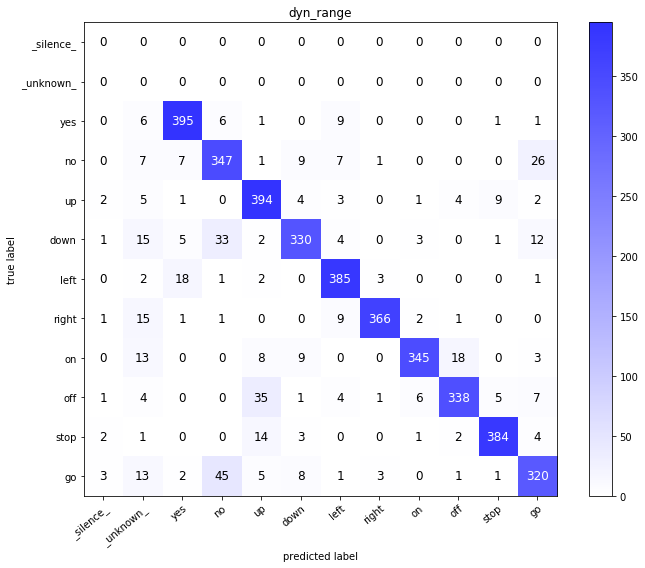

In [22]:
visualize_confusion_matrix(df, cm_clean, 0, labels, "dyn_range", "true_label", "clean_guess")

Visualize the confusion matrix for the errorified data.

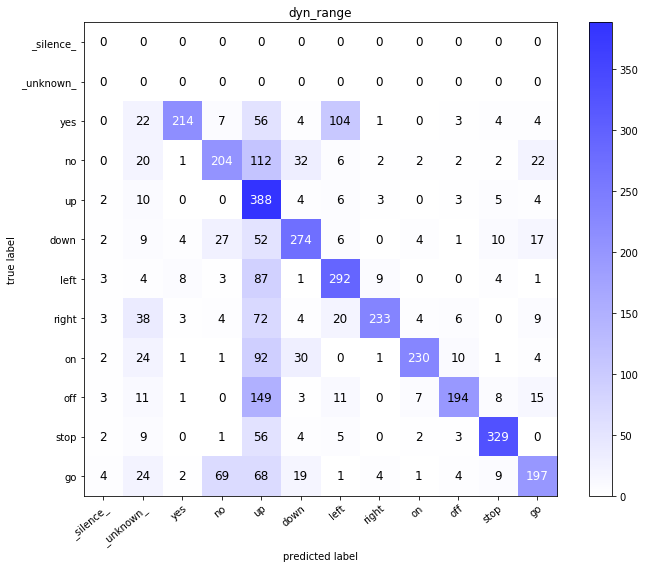

In [23]:
visualize_confusion_matrix(df, cm_err, 0, labels, "dyn_range", "true_label", "err_guess")